<a href="https://colab.research.google.com/github/yusica09/seoul-AI-hub-study/blob/main/2%EC%A3%BC%EC%B0%A8/Q5_fashion_MNIST_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.15.0'

### 데이터 로드
* TF에서 제공하는 데이터셋을 load해 간단한 전처리 진행

In [40]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.fashion_mnist.load_data()

In [41]:
print(train_data.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [42]:
train_data, valid_data, train_labels, valid_labels = \
    train_test_split(train_data, train_labels, test_size=0.1, shuffle=True)

In [43]:
print(train_data.shape, train_labels.shape)

(54000, 28, 28) (54000,)


In [44]:
print(valid_data.shape, valid_labels.shape)

(6000, 28, 28) (6000,)


label = 8


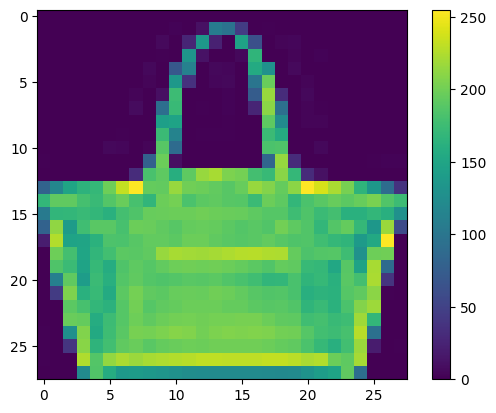

In [45]:
index = 5901
print("label = {}".format(valid_labels[index]))
plt.imshow(valid_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

In [46]:
train_data = train_data / 255.
train_data = train_data.reshape(-1, 28*28)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 28*28)
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

valid_data = valid_data / 255.
valid_data = valid_data.reshape(-1, 28*28)
valid_data = valid_data.astype(np.float32)
valid_labels = valid_labels.astype(np.int32)


print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)


(54000, 784) (54000,)
(10000, 784) (10000,)
(6000, 784) (6000,)


### 학습에 사용할 tf.data.Dataset 구성
* 학습에 잘 적용할 수 있도록 label 처리
* 데이터셋 구성

In [47]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10)
  return image, label

In [48]:
batch_size = 32

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

# for test
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels))
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

# print를 이용하여 정보를 확인하는 것이 중요

<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### 모델 구성

In [52]:
# Dense 64 relu
# Dense 32 relu
# Output Layer
# input shape은 실수하는 경우가 많으므로 자동으로 가져오게 하는 편이 좋다.
# 28 * 28
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(10)
])

In [53]:
# from_logits = True 잊지말기
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
# without training, just inference a model in eager execution:
predictions = model(train_data[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[-0.12047834 -0.00034373  0.0451146   0.03338142 -0.05239188 -0.18060885
  -0.12920743 -0.2452113  -0.10624401  0.04954673]]


In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (1, 64)                   50240     
                                                                 
 dense_10 (Dense)            (1, 32)                   2080      
                                                                 
 dense_11 (Dense)            (1, 16)                   528       
                                                                 
 dense_12 (Dense)            (1, 10)                   170       
                                                                 
Total params: 53018 (207.10 KB)
Trainable params: 53018 (207.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 모델 학습 구성

In [56]:
check_point_cb = callbacks.ModelCheckpoint('fashion_mnist_model.h5',
                                           save_best_only=True,
                                           verbose=1)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor='val_loss',
                                            restore_best_weights=True,
                                            verbose=1)

In [57]:
max_epochs = 100
# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=len(train_data) // batch_size,
                    validation_data=valid_dataset,
                    validation_steps=len(valid_data) // batch_size,
                    callbacks=[check_point_cb, early_stopping_cb]
                   )

Epoch 1/100
1676/1687 [============================>.] - ETA: 0s - loss: 0.8920 - accuracy: 0.7221
Epoch 1: val_loss improved from inf to 0.56467, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 13s 5ms/step - loss: 0.8897 - accuracy: 0.7228 - val_loss: 0.5647 - val_accuracy: 0.8118
Epoch 2/100
1681/1687 [============================>.] - ETA: 0s - loss: 0.5112 - accuracy: 0.8297
Epoch 2: val_loss improved from 0.56467 to 0.48690, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 8s 5ms/step - loss: 0.5110 - accuracy: 0.8296 - val_loss: 0.4869 - val_accuracy: 0.8319
Epoch 3/100
1687/1687 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.8435
Epoch 3: val_loss improved from 0.48690 to 0.44887, saving model to fashion_mnist_model.h5
1687/1687 [==============================] - 9s 5ms/step - loss: 0.4577 - accuracy: 0.8435 - val_loss: 0.4489 - val_accuracy: 0.8416
Epoch 4/100
1681/1687 [===========

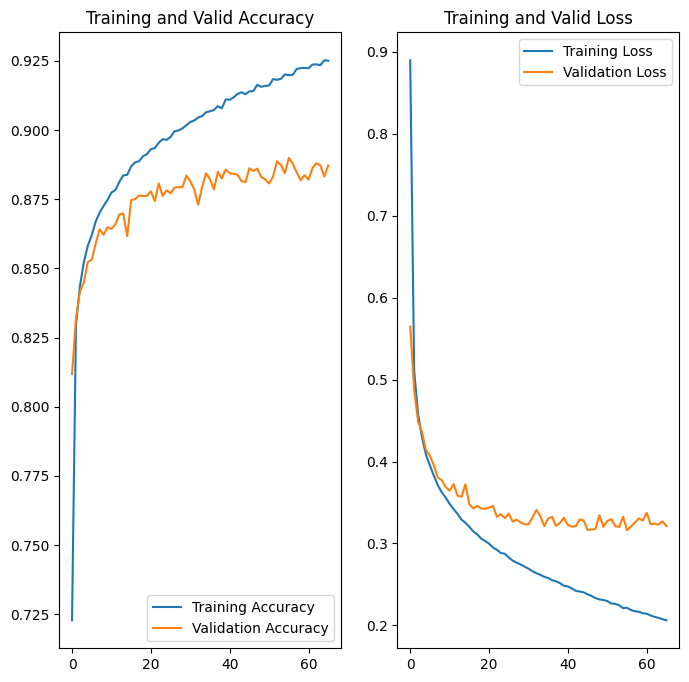

In [58]:
# 그래프에서 1)학습이 잘되었는지 확인 2)overfitting 발생여부 3)개선방향
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

In [59]:
results = model.evaluate(test_dataset)

313/313 [==============================] - 1s 3ms/step - loss: 0.3531 - accuracy: 0.8792
